In [6]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,10)})

df = pd.read_csv(os.path.join('data','voice.csv'))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [27]:
train_x = torch.tensor(
    [[0, 0], [0, 1], [1, 0]],
    dtype=torch.float32, device=device)

train_y = torch.tensor(
    [[0], [1], [1]],
    dtype=torch.float32, device=device)

test_x = torch.tensor(
    [[1,1]],
    dtype=torch.float32, device=device)

test_y = torch.tensor(
    [[0]],
    dtype=torch.float32, device=device)

100 0.5106444954872131
200 0.2723609507083893
300 0.12399546802043915
400 0.07557620108127594
500 0.05251016467809677
600 0.03957466036081314
700 0.03147104009985924
800 0.025983817875385284
900 0.022045031189918518
1000 0.01908973976969719
Y	Y'
[1.0, 1.0] [0.9999977350234985]


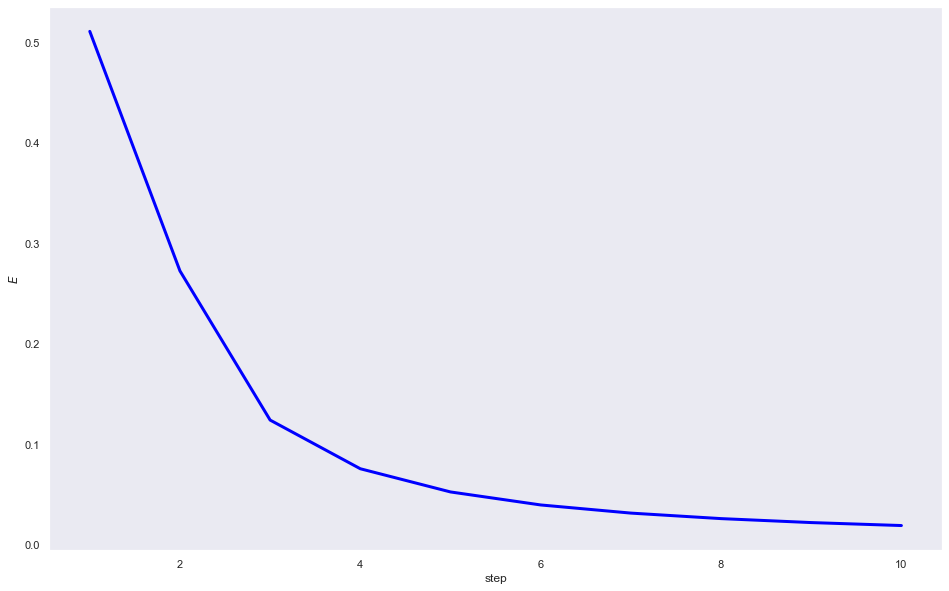

In [45]:
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size, device=device)
        self.relu = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(hidden_size, num_classes, device=device)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out) 
        
        return out #Return logits

#Initialise model, optimiser and history
model = Model(2,10,1)
model.to(device)
optimiser = torch.optim.SGD(model.parameters(),lr=0.1)
history = []

#Epoch Training
for step in range(1, 1000+1):
    optimiser.zero_grad()
    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())
        history.append(error.tolist())
        

#Testing 
with torch.no_grad():
    print('Y\tY\'')
    outputs = torch.sigmoid(model(test_x))
    for (x, output) in zip(test_x, outputs):
        print(x.tolist(), output.tolist())

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(history) + 1), history, color='blue', linestyle='-', linewidth=3)
ax.grid()
    

In [40]:
error.tolist()

0.22306816279888153